# Imports and preprocessing

In [20]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm_notebook

from src.onset_detection import OnsetDetection

Load data

In [21]:
DATA_PATH = Path('./data/')

df_description = pd.DataFrame()
signals = None


for i, path in enumerate(sorted(DATA_PATH.glob('*.data'))):
    with open(path, 'rb') as file:
        loaded = pd.read_pickle(file)

        loaded_description = loaded[0]
        loaded_description['class'] = i
        loaded_signals = loaded[1]

        df_description = pd.concat([df_description, loaded_description], ignore_index=True)
        if signals is None: 
            signals = loaded_signals
        else: 
            signals = np.concat([signals, loaded_signals])

Onset detection

In [22]:
out_size = 512
od = OnsetDetection(window_step=10, out_length=out_size, downsampling=2)
short_signals = np.empty((len(signals), 256))

for i in tqdm_notebook(range(len(signals))):
    

    _, short_sig = od(signals[i])

    short_signals[i, :] = short_sig

  0%|          | 0/32008 [00:00<?, ?it/s]

### Time-frequency tests

(65, 167)

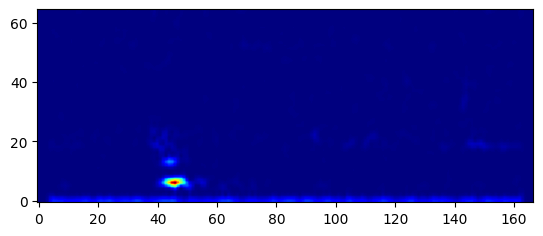

In [23]:
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

# Step 1: Generate a sample signal
signal = signals[0][::2]
signal = signal / np.max(signal) 

fs = 4*1e9  # Sampling frequency
t = np.arange(len(signal)) / fs  # Time vector

w = gaussian(128, std=16, sym=True)  # symmetric Gaussian window

# A sample signal: sum of two sine waves with different frequencies


# Step 2: Compute the Short-Time Fourier Transform (STFT)
STF = ShortTimeFFT(w, hop=16, fs=fs, scale_to='psd')
Sx = STF.spectrogram(signal)

#Sx = 10 * np.log10(np.fmax(Sx, 1e-10))  # limit range to -40 dB

im1 = plt.imshow(Sx, origin='lower', cmap='jet')
# # Step 3: Plot the STFT magnitude
# plt.figure(figsize=(10, 6))
# plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
# plt.title('STFT Magnitude')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.colorbar(label='Magnitude')
# plt.show()

Sx.shape

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(short_signals)
y = df_description['class'].values

# Model setup

## Dataset definition

In [25]:
def stratified_train_test_split(X, y=None, ratio=0.8):
    # Classes are put one after another, normal train-test split wont work.
    # NONRANDOM

    X = np.asarray(X)
    y = np.asarray(y)

    # Define vars
    int_ratio = int(1 / (1 - ratio))
    int_len_X = int(len(X))
    
    test_indices = np.arange(0, int_len_X, int_ratio)

    # Get boolean indexing
    train_boolean = [False if i in test_indices else True for i in range(int_len_X)]
    test_boolean = [not i for i in train_boolean]

    if y is not None:
        return X[train_boolean], y[train_boolean], X[test_boolean], y[test_boolean]

    return X[train_boolean], X[test_boolean]

In [26]:
X_train, y_train, X_test, y_test = stratified_train_test_split(X_scaled, y, 0.8)
X_train, y_train, X_val, y_val = stratified_train_test_split(X_train, y_train, 0.8)

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [28]:
class PDDataset(Dataset):
    def __init__(self, X, y, transform = None):
        self.signals = X
        self.labels = y
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        
        signal = self.signals[index].astype(np.float32)
        label = self.labels[index]

        if self.transform:
            signal = self.transform(signal)

        return signal, label

In [29]:
train_dataset = PDDataset(X_train, y_train)
test_dataset = PDDataset(X_test, y_test)
val_dataset = PDDataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 256])
Labels batch shape: torch.Size([64])


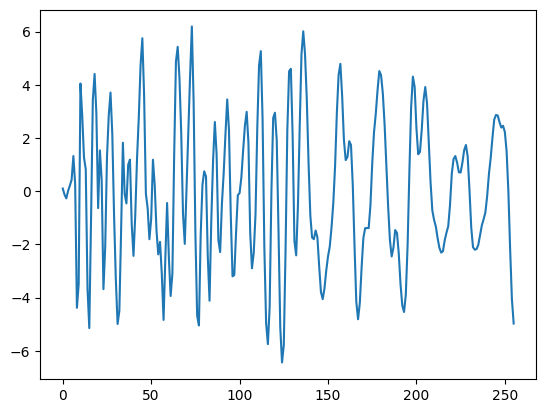

Label: 7


In [30]:
# TEST

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


signal = train_features[0].squeeze()
label = train_labels[0]
plt.plot(signal)
plt.show()
print(f"Label: {label}")

## Model Definition

In [31]:
class ArtNeuralNetwork(torch.nn.Module):
    def __init__(self, input_shape, label_shape):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_stack = torch.nn.Sequential(
            torch.nn.Linear(input_shape[1], 256),
            torch.nn.ReLU(), 
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, label_shape)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

In [32]:
model = ArtNeuralNetwork(train_features.size(), len(np.unique(y)))
model.to(device)
print(model)

ArtNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=8, bias=True)
  )
)


In [33]:
logits = model(next(iter(train_dataloader))[0].to(device))
pred_probab = torch.nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([6, 4, 4, 6, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        6, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 2, 4, 6, 4, 4, 4, 6, 4, 4, 4, 4, 4], device='cuda:0')


In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [34]:
def train_loop(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)

    model.train()

    for batch, (X, y) in enumerate(dataloader):

        pred = model(X)
        loss = loss_function(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch%100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
        